In [1]:
import pandas as pd
import numpy as np
import ast  # For safe evaluation of Python-like strings
from transformers import BertTokenizer
import pickle as pkl
from dataset import RedlistDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import AdamW
from model_tax import RedlistPredictor
from tqdm import tqdm
from transformers import get_scheduler
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [8]:
with open("data/data_splits.pkl", "rb") as f:
    data = pkl.load(f)

df_train = data["train"]
df_test = data["test"]
df_deficient = data["deficient"]

In [5]:
label_to_category = {
    0: 'Least Concern',
    1: 'Near Threatened',
    2: 'Vulnerable',
    3: 'Endangered',
    4: 'Critically Endangered',
    5: 'Extinct'
}

In [9]:
df_train_copy = df_train.copy()

# Replace [REDACTED] in the 'rationale' column with the corresponding category
df_train_copy['rationale'] = df_train_copy.apply(
    lambda row: row['rationale'].replace('[REDACTED]', label_to_category[row['redlistCategory']-1]),
    axis=1
)

In [7]:
df_train_copy

,assessmentId,scientificName,internalTaxonId,redlistCategory,rationale,habitat,threats,population,range,useTrade,...,className,orderName,familyName,genusName,className_idx,orderName_idx,familyName_idx,genusName_idx,structured_vector,text_input
33026,115129406,Oxymycterus angularis,15783,1,this species is listed as Least Concern in vie...,this species occurs in tropical dry shrubland...,there are no major threats to this species.,very little is known of populations of this sp...,this species occurs in extreme eastern brazil ...,,...,MAMMALIA,RODENTIA,CRICETIDAE,Oxymycterus,3,19,42,4052,"[1.5563551401869158, 0.0, 0.0, 0.0, 0.0, 0.0, ...",this species is listed as [REDACTED] in view o...
7587,6517153,Physoschistura shanensis,168570,2,hora (1929) described nemachilus shanensis fr...,the species is found dwelling in a shallow lak...,invasive species of fish (e.g. tilapia) have b...,no information is available; requires further ...,known only from tributaries and the shores of ...,the species is thought to be of no interest in...,...,ACTINOPTERYGII,CYPRINIFORMES,NEMACHEILIDAE,Physoschistura,2,14,83,549,"[1.5563551401869158, 0.0, 0.0, 0.0, 0.0, 1.0, ...",hora (1929) described nemachilus shanensis fr...
41441,151858712,Rhynchobatus cooki,60181,5,the clown wedgefish ( rhynchobatus cooki ) is ...,exact details of the habitat of the clown wedg...,"globally, wedgefishes are subject to intense f...",where rhinopristoid rays (sawfishes [pristidae...,the clown wedgefish is known from specimens co...,wedgefishes are heavily utilized across their ...,...,CHONDRICHTHYES,RHINOPRISTIFORMES,RHINIDAE,Rhynchobatus,0,21,272,1356,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",the clown wedgefish ( rhynchobatus cooki ) is ...
5418,2760858,Anolis tropidolepis,203125,1,this species is listed as Least Concern due to...,this species occurs in lower montane wet and r...,there are no known threats to this adaptable s...,this is an abundant species throughout its ran...,the species is endemic to the mountains of cos...,this species is not utilized or traded to any ...,...,REPTILIA,SQUAMATA,ANOLIDAE,Anolis,1,5,148,442,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",this species is listed as [REDACTED] due to it...
39348,137341584,Telestes turskyi,61351,4,tursky's dace has a restricted range (extent o...,the čikola is a temporal karstic river charact...,the source spring of the čikola river is explo...,this species' current population trend has not...,"this species is endemic to the čikola river, a...",this species is not used or traded.,...,ACTINOPTERYGII,CYPRINIFORMES,LEUCISCIDAE,Telestes,2,14,29,6742,"[1.5563551401869158, 0.0, 0.0, 1.0, 0.0, 0.0, ...",tursky's dace has a restricted range (extent o...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27343,85884075,Strabomantis sulcatus,56983,1,listed as Least Concern in view of its wide di...,this species can be found in primary tropical ...,there are presumably no major threats as it is...,it is a rarely observed species. the populatio...,this species is present throughout much of the...,there are no records of this species being uti...,...,AMPHIBIA,ANURA,STRABOMANTIDAE,Strabomantis,4,9,23,1795,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",listed as [REDACTED] in view of its wide distr...
30902,102830477,Delma butleri,102830450,1,listed as Least Concern in view of its wide di...,"this species prefers semi-arid to arid areas, ...",there are no threats to this widespread and ad...,"it is an abundant species, with a stable popul...","this species is endemic to australia, found fr...",there appears to be no use or trade in this sp...,...,REPTILIA,SQUAMATA,PYGOPODIDAE,Delma,1,5,628,5771,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",listed as [REDACTED] in view of its wide distr...
42224,156742081,Phoxinus brachyurus,156742076,3,"seven river's minnow inhabits small, usually i...","seven river's minnow inhabits usually small, i...","habitat destruction due

In [3]:
df_train['systems_vector']

33026    [0, 0, 1]
7587     [1, 0, 0]
41441    [0, 1, 0]
5418     [0, 0, 1]
39348    [1, 0, 0]
           ...    
27343    [0, 0, 1]
30902    [0, 0, 1]
42224    [1, 0, 0]
38736    [1, 0, 0]
22781    [1, 0, 0]
Name: systems_vector, Length: 33933, dtype: object

In [4]:
df_train.columns

Index(['assessmentId', 'scientificName', 'internalTaxonId', 'redlistCategory',
       'rationale', 'habitat', 'threats', 'population', 'range', 'useTrade',
       'conservationActions', 'populationTrend', 'possiblyExtinct',
       'possiblyExtinctInTheWild', 'realm_vector', 'systems_vector',
       'className', 'orderName', 'familyName', 'genusName', 'className_idx',
       'orderName_idx', 'familyName_idx', 'genusName_idx', 'structured_vector',
       'text_input'],
      dtype='object')

In [5]:
for df_name, df in [("df_train", df_train), ("df_test", df_test), ("df_deficient", df_deficient)]:
    avg_nulls_per_row = df.isnull().sum(axis=1).mean()
    print(f"Average number of null/None values per row in {df_name}: {avg_nulls_per_row:.2f}")

Average number of null/None values per row in df_train: 0.00
Average number of null/None values per row in df_test: 0.00
Average number of null/None values per row in df_deficient: 0.00


In [6]:
print(df_train.columns)
print(df_train['structured_vector'].iloc[0].shape)  # Should be a NumPy array
print(df_train['text_input'].iloc[0][:1000])  # First 100 characters of a sample text input

Index(['assessmentId', 'scientificName', 'internalTaxonId', 'redlistCategory',
       'rationale', 'habitat', 'threats', 'population', 'range', 'useTrade',
       'conservationActions', 'populationTrend', 'possiblyExtinct',
       'possiblyExtinctInTheWild', 'realm_vector', 'systems_vector',
       'className', 'orderName', 'familyName', 'genusName', 'className_idx',
       'orderName_idx', 'familyName_idx', 'genusName_idx', 'structured_vector',
       'text_input'],
      dtype='object')
(15,)
this species is listed as [REDACTED] in view of its wide distribution, presumed large population, and because it is unlikely to be declining at nearly the rate required to qualify for listing in a threatened category. [SEP] this species occurs in tropical  dry shrublands and open habitat. [SEP] there are no major threats to this species. [SEP] very little is known of populations of this species [SEP] this species occurs in extreme eastern brazil (alagoas, ceará, pernambuco) (musser and carleton,

In [7]:
taxonomy_levels=['className_idx', 'orderName_idx', 'familyName_idx', 'genusName_idx']
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = RedlistDataset(df_train, tokenizer, taxonomy_levels)
test_dataset = RedlistDataset(df_test, tokenizer, taxonomy_levels)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tax_vocab_size = {
    'className_idx': 8,
    'orderName_idx': 101,
    'familyName_idx': 878,
    'genusName_idx': 7618
}

model = RedlistPredictor(
    bert_model_name='bert-base-uncased',
    structured_input_dim=len(df_train.iloc[0]['structured_vector']),
    taxonomy_vocab_sizes=tax_vocab_size,
    hidden_dim=256,
    num_classes=6
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            structured_input = batch['structured_input'].to(device)
            labels = batch['label'].to(device)
            taxonomy = batch['taxonomy'].to(device)

            logits = model(input_ids, attention_mask, structured_input, taxonomy)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Loss: {avg_loss:.4f}")

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }, all_preds


In [10]:
# load the model from checkpoint
checkpoint_path = f"checkpoints_tax/checkpoint_epoch_3.pt"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

RedlistPredictor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [11]:
test_res3 = checkpoint['test_results']
test_res3

{'loss': 0.13258866290545412,
 'accuracy': 0.9590994813767091,
 'precision': 0.9077140062454455,
 'recall': 0.9109218217918137,
 'f1': 0.9088763985059612}

In [12]:
for i, level in enumerate(model.taxo_embeddings.keys() ):
    print(i, level)


0 className_idx
1 orderName_idx
2 familyName_idx
3 genusName_idx


In [ ]:
num_epochs = 6  # You can increase this
total_steps = len(train_loader) * num_epochs

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_one_epoch_with_progress(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    total_loss = 0
    all_losses = []
    for batch_idx, batch in enumerate(loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)
        labels = batch['label'].to(device)
        taxonomy = batch['taxonomy'].to(device)

        logits = model(input_ids, attention_mask, structured_input, taxonomy)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        total_loss += loss.item()
        all_losses.append(loss.item())

        if (batch_idx + 1) % 100 == 0:
            print(f"Batch {batch_idx + 1}/{len(loader)} - Loss: {loss.item():.4f}")

    return total_loss / len(loader), all_losses

checkpoint_dir = "checkpoints_tax"
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []

for epoch in range(5, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")
    train_loss, losses_epoch = train_one_epoch_with_progress(model, train_loader, optimizer, criterion, scheduler)
    test_res, test_preds = evaluate(model, test_loader, criterion)
    # val_loss = val_res['loss']
    train_losses.append(train_loss)

    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {test_res['loss']:.4f}")
    print(f"  Val Acc:    {test_res['accuracy']:.4f}")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'test_results': test_res,
        'test_preds': test_preds,
    }
    torch.save(checkpoint, f"{checkpoint_dir}/checkpoint_epoch_{epoch}.pt")

Epoch 5/6


100%|██████████| 531/531 [02:22<00:00,  3.72it/s]                           


Accuracy: 0.9554
Precision: 0.9001
Recall: 0.9096
F1 Score: 0.9032
Loss: 0.1636
  Train Loss: 0.0627
  Val Loss:   0.1636
  Val Acc:    0.9554
Epoch 6/6


Training:  48%|████▊     | 1027/2121 [10:12<13:05,  1.39it/s, loss=0.0129]  

In [24]:
df_train

,assessmentId,scientificName,internalTaxonId,redlistCategory,rationale,habitat,threats,population,range,useTrade,...,className,orderName,familyName,genusName,className_idx,orderName_idx,familyName_idx,genusName_idx,structured_vector,text_input
33026,115129406,Oxymycterus angularis,15783,1,this species is listed as [REDACTED] in view o...,this species occurs in tropical dry shrubland...,there are no major threats to this species.,very little is known of populations of this sp...,this species occurs in extreme eastern brazil ...,,...,MAMMALIA,RODENTIA,CRICETIDAE,Oxymycterus,3,19,42,4052,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]",this species is listed as [REDACTED] in view o...
7587,6517153,Physoschistura shanensis,168570,2,hora (1929) described nemachilus shanensis fr...,the species is found dwelling in a shallow lak...,invasive species of fish (e.g. tilapia) have b...,no information is available; requires further ...,known only from tributaries and the shores of ...,the species is thought to be of no interest in...,...,ACTINOPTERYGII,CYPRINIFORMES,NEMACHEILIDAE,Physoschistura,2,14,83,549,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]",hora (1929) described nemachilus shanensis fr...
41441,151858712,Rhynchobatus cooki,60181,5,the clown wedgefish ( rhynchobatus cooki ) is ...,exact details of the habitat of the clown wedg...,"globally, wedgefishes are subject to intense f...",where rhinopristoid rays (sawfishes [pristidae...,the clown wedgefish is known from specimens co...,wedgefishes are heavily utilized across their ...,...,CHONDRICHTHYES,RHINOPRISTIFORMES,RHINIDAE,Rhynchobatus,0,21,272,1356,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",the clown wedgefish ( rhynchobatus cooki ) is ...
5418,2760858,Anolis tropidolepis,203125,1,this species is listed as [REDACTED] due to it...,this species occurs in lower montane wet and r...,there are no known threats to this adaptable s...,this is an abundant species throughout its ran...,the species is endemic to the mountains of cos...,this species is not utilized or traded to any ...,...,REPTILIA,SQUAMATA,ANOLIDAE,Anolis,1,5,148,442,"[2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]",this species is listed as [REDACTED] due to it...
39348,137341584,Telestes turskyi,61351,4,tursky's dace has a restricted range (extent o...,the čikola is a temporal karstic river charact...,the source spring of the čikola river is explo...,this species' current population trend has not...,"this species is endemic to the čikola river, a...",this species is not used or traded.,...,ACTINOPTERYGII,CYPRINIFORMES,LEUCISCIDAE,Telestes,2,14,29,6742,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]",tursky's dace has a restricted range (extent o...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27343,85884075,Strabomantis sulcatus,56983,1,listed as [REDACTED] in view of its wide distr...,this species can be found in primary tropical ...,there are presumably no major threats as it is...,it is a rarely observed species. the populatio...,this species is present throughout much of the...,there are no records of this species being uti...,...,AMPHIBIA,ANURA,STRABOMANTIDAE,Strabomantis,4,9,23,1795,"[2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]",listed as [REDACTED] in view of its wide distr...
30902,102830477,Delma butleri,102830450,1,listed as [REDACTED] in view of its wide distr...,"this species prefers semi-arid to arid areas, ...",there are no threats to this widespread and ad...,"it is an abundant species, with a stable popul...","this species is endemic to australia, found fr...",there appears to be no use or trade in this sp...,...,REPTILIA,SQUAMATA,PYGOPODIDAE,Delma,1,5,628,5771,"[2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",listed as [REDACTED] in view of its wide distr...
42224,156742081,Phoxinus brachyurus,156742076,3,"seven river's minnow inhabits small, usually i...","seven river's minnow inhabits usually small, i...","habitat destruction due to urbanisation, water...",

In [28]:
with open('results.pkl', 'rb') as f:
    test_res3 = pkl.load(f)

test_res3

{'loss': 0.15133409391734143,
 'accuracy': 0.9503771805752004,
 'precision': 0.8918673902665004,
 'recall': 0.8922087168261914,
 'f1': 0.8917366953953826}

In [ ]:
# with open('results.pkl', 'rb') as f:
#     results_allepochs = pkl.load(f)
#     test_true_labels = pkl.load(f)
#     val_true_labels = pkl.load(f)

# test_metrics = results_allepochs[1]['test_metrics']
# val_metrics = results_allepochs[1]['val_metrics']
# test_predictions = results_allepochs[1]['test_predictions']
# val_predictions = results_allepochs[1]['val_predictions']

In [ ]:
# with open('results.pkl', 'rb') as f:
#     results = pkl.load(f)

# test_metrics = results['test_metrics']
# val_metrics = results['val_metrics']
# test_predictions = results['test_predictions']
# val_predictions = results['val_predictions']

In [15]:
label_to_category = {
    0: 'Least Concern',
    1: 'Near Threatened',
    2: 'Vulnerable',
    3: 'Endangered',
    4: 'Critically Endangered',
    5: 'Extinct'
}

In [16]:
class_labels = [f'{id}: {label_to_category[id]}' for id in range(6)]

def plot_confusion_matrix(true_labels, predicted_labels, is_normalized, title_str=''):
    
    if is_normalized:
        cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    else:
        cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues", xticklabels=range(6), yticklabels=class_labels)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    if is_normalized:
        plt.title("Confusion Matrix (Normalized)"+title_str)
    else:
        plt.title("Confusion Matrix (Raw Counts)"+title_str)
    plt.show()

In [12]:
test_true_labels = [sample['label'] for sample in test_dataset]

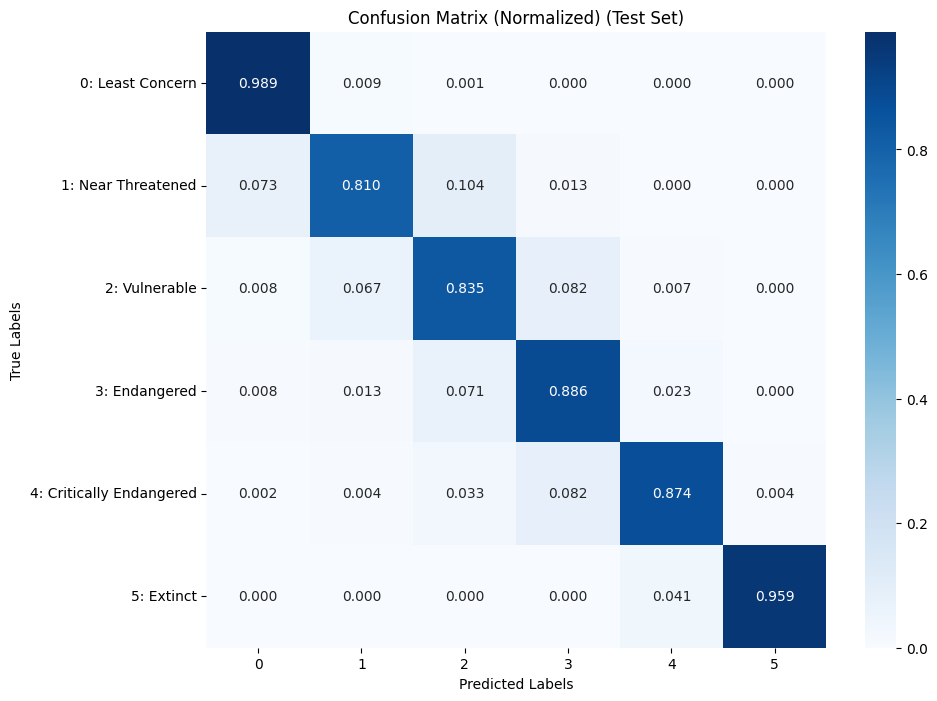

In [17]:
plot_confusion_matrix(test_true_labels, test_preds, is_normalized=True, title_str=' (Test Set)')

Predict the data deficient (unlabeled) data

In [18]:
# Create a dataset and dataloader for df_deficient
deficient_dataset = RedlistDataset(df_deficient, tokenizer)
deficient_loader = DataLoader(deficient_dataset, batch_size=16)

# Make predictions
model.eval()
deficient_predictions = []

with torch.no_grad():
    for batch in tqdm(deficient_loader, desc="Predicting on df_deficient"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)

        logits = model(input_ids, attention_mask, structured_input)
        preds = torch.argmax(logits, dim=1)
        deficient_predictions.extend(preds.cpu().numpy())

print("Predictions on df_deficient:", deficient_predictions)

Predicting on df_deficient: 100%|██████████| 512/512 [01:31<00:00,  5.57it/s]

Predictions on df_deficient: [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0, 3, 2, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 4, 3, 2, 0, 3, 0, 0, 2, 4, 3, 1, 2, 2, 0, 0, 0, 0, 5, 5, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 1, 3, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 1, 3, 0, 0, 0, 4, 0, 4, 0, 0, 1, 0, 0, 5

In [23]:
from collections import Counter

# Count the occurrences of each unique value in deficient_predictions
unique_counts = Counter(deficient_predictions)

# Print the unique value counts
print("Unique value counts of df_deficient predictions:")
for category, count in sorted(unique_counts.items()):
    print(f"Category {category}: {count}, {count/len(deficient_predictions):.4f}")

Unique value counts of df_deficient predictions:
Category 0: 6283, 0.7680
Category 1: 805, 0.0984
Category 2: 486, 0.0594
Category 3: 141, 0.0172
Category 4: 283, 0.0346
Category 5: 183, 0.0224


In [24]:
import torch.nn.functional as F

deficient_predictions = []
deficient_confidences = []
deficient_all_probs = []

model.eval()
with torch.no_grad():
    for batch in tqdm(deficient_loader, desc="Predicting on df_deficient"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)

        logits = model(input_ids, attention_mask, structured_input)
        probs = F.softmax(logits, dim=1)  # Convert logits to probabilities

        top_probs, top_preds = torch.max(probs, dim=1)

        deficient_predictions.extend(top_preds.cpu().numpy())
        deficient_confidences.extend(top_probs.cpu().numpy())
        deficient_all_probs.extend(probs.cpu().numpy()) 

Predicting on df_deficient: 100%|██████████| 512/512 [01:31<00:00,  5.57it/s]


In [25]:
with open('results.pkl', 'wb') as f:
    pkl.dump(test_res, f)
    pkl.dump(test_preds, f)
    pkl.dump(test_true_labels, f)
    pkl.dump(deficient_predictions, f)
    pkl.dump(deficient_confidences, f)
    pkl.dump(deficient_all_probs, f)

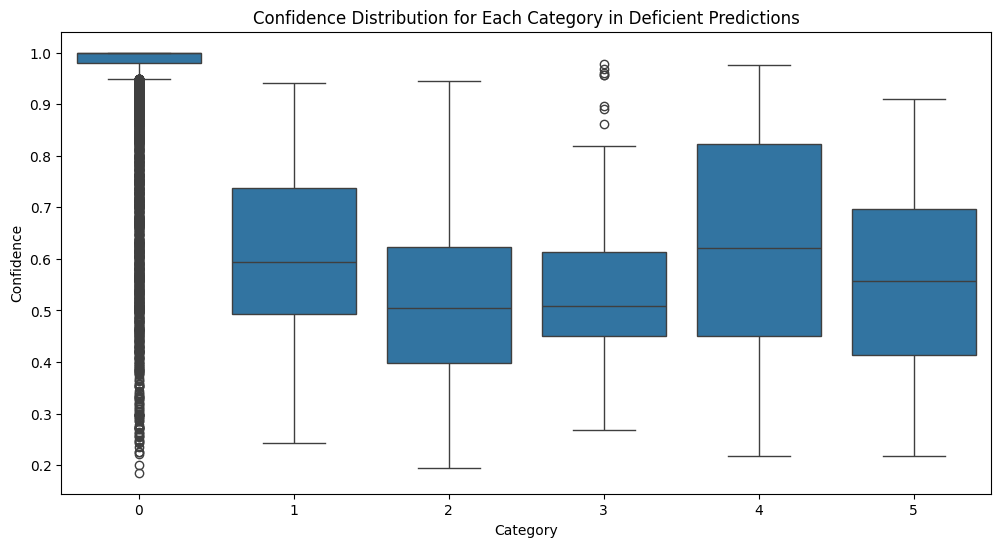

In [26]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Create a DataFrame for visualization
data = pd.DataFrame({
    'Category': deficient_predictions,
    'Confidence': deficient_confidences
})

# Plot the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Confidence', data=data)
plt.title('Confidence Distribution for Each Category in Deficient Predictions')
plt.xlabel('Category')
plt.ylabel('Confidence')
plt.show()

[0.6216753,
 0.9905874,
 0.99179816,
 0.8776516,
 0.9939692,
 0.9780593,
 0.9975574,
 0.99274385,
 0.83246124,
 0.5236646,
 0.9976877,
 0.99891305,
 0.9995382,
 0.9993236,
 0.8713883,
 0.30896962,
 0.30848664,
 0.99889827,
 0.99451727,
 0.62912285,
 0.9160517,
 0.9945604,
 0.99456537,
 0.99769586,
 0.9990404,
 0.7510684,
 0.993601,
 0.99287826,
 0.9993061,
 0.99385023,
 0.99635845,
 0.7606327,
 0.9947915,
 0.99279976,
 0.9755518,
 0.8191193,
 0.8450525,
 0.9969015,
 0.9743463,
 0.9690027,
 0.9963611,
 0.9957659,
 0.99566525,
 0.99128646,
 0.9979183,
 0.98537505,
 0.9901754,
 0.9976077,
 0.9550177,
 0.9955254,
 0.9639395,
 0.7302365,
 0.9609099,
 0.99823534,
 0.86411774,
 0.9787612,
 0.992432,
 0.84074324,
 0.9964133,
 0.8290737,
 0.99669313,
 0.9986619,
 0.97182244,
 0.99724066,
 0.99820495,
 0.99961996,
 0.9058054,
 0.8474682,
 0.99840957,
 0.9761263,
 0.99695146,
 0.99780434,
 0.99024475,
 0.88864905,
 0.9865242,
 0.9805088,
 0.848658,
 0.7740639,
 0.99852484,
 0.9964575,
 0.99867344

In [43]:
from collections import Counter

# Count the occurrences of each category in the predictions
category_counts = Counter(deficient_predictions)

# Calculate the normalized counts
total_predictions = len(deficient_predictions)
normalized_counts = {category: count / total_predictions for category, count in category_counts.items()}

# Print the results
print("Category Counts:", category_counts)
print("Normalized Counts:", normalized_counts)

Category Counts: Counter({0: 7817, 2: 177, 4: 112, 3: 38, 1: 21, 5: 16})
Normalized Counts: {2: 0.021635496883021636, 0: 0.9555066617772888, 1: 0.002566923359002567, 3: 0.004644908935337979, 4: 0.013690257914680357, 5: 0.0019557511306686226}


In [ ]:
df_deficient 

,assessmentId,scientificName,redlistCategory,rationale,habitat,threats,population,range,useTrade,conservationActions,populationTrend,possiblyExtinct,possiblyExtinctInTheWild,realm_vector,systems_vector,structured_vector,text_input
3,498370,Ictalurus australis,0,ictalurus australis occurs in eastern mexico f...,i. australis inhabits quiet and slow-flowing w...,the main threat faced by this species is overf...,numerical estimates of population sizes and po...,ictalurus australis is distributed in the blan...,i. australis is primarily harvested and highly...,the american fisheries society endangered spec...,1,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]",ictalurus australis occurs in eastern mexico f...
6,498726,Iguanognathus werneri,0,this species is only known from the historical...,no information about habitat and ecology of th...,no information is available about threats to t...,no population data is available.,this species is only known from the type speci...,there are no reports of this species being uti...,research is needed to establish the current di...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",this species is only known from the historical...
10,500780,Lagocephalus gloveri,0,lagocephalus gloveri is distributed from the a...,lagocephalus gloveri is a tropical species fou...,pufferfish fishery lagocephalus gloveri is imp...,lagacephalus gloveri is common and can be loca...,lagocephalus gloveri is known from the andaman...,lagocephalus gloveri is widely utilized in the...,fisheries lagocephalus gloveri is a component ...,1,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]",lagocephalus gloveri is distributed from the a...
39,518740,Myotis alcathoe,0,european regional and global assessment: data ...,"according to present scarce knowledge, the alc...",damage to riparian forest is believed be a thr...,this species’ population size and trend are un...,the alcathoe myotis ( myotis alcathoe ) was re...,NaN,it is protected by national legislation in mos...,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]",european regional and global assessment: data ...
51,546543,Notropis imeldae,0,notropis imeldae is known to occur in central ...,notropis imeldae is known to inhabit headwater...,the threats to notropis imeldae are unknown.,more information is needed regarding the popul...,notropis imeldae is known to occur in central ...,more information is required regarding the pos...,there are no known conservation efforts for th...,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]",notropis imeldae is known to occur in central ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50609,259373781,Tupaia hypochrysa,0,"the species is listed as data deficient, in vi...",the habitat requirements and ecology of this s...,the major threat to this species is severe def...,no information is available on population size...,"the species is endemic to the island of java, ...",NaN,it is not known if the species is found within...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]","the species is listed as data deficient, in vi..."
50610,259374022,Tupaia ferruginea,0,as this is a recently resurrected species ther...,the habitat requirements and ecology of this s...,the major threat to this species is severe def...,information is not available on population siz...,is found on the island of sumatra and the batu...,NaN,it is not known if this species is found withi...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",as this is a recently resurrected species ther...
50612,259374358,Tupaia discolor,0,"this species is listed as data deficient, in v...",there is no information about the habitat requ...,extensive tin mining on bangka island has caus...,there is no information abou

Check feature importance

In [46]:
with torch.no_grad():
    weight_matrix = model.struct_proj.weight.cpu().numpy()  # shape: [hidden_dim, structured_input_dim]

# Compute average absolute weight per input dimension
importance_per_dim = np.mean(np.abs(weight_matrix), axis=0)  # shape: [structured_input_dim]

In [52]:
importance_per_dim

array([0.1335739 , 0.14949572, 0.14989133, 0.15068196, 0.14395387,
       0.15354574, 0.14554542, 0.14068334, 0.13332412, 0.1454425 ,
       0.14919978, 0.14805786], dtype=float32)

In [54]:
dim_pop_trend = 0  
dim_possibly_extinct = 0
dim_possibly_extinct_in_wild = 0
dim_realm = len(df_train.iloc[0]['realm_vector'])  # e.g., 9
dim_systems = len(df_train.iloc[0]['systems_vector'])  # e.g., 3

# Compute start/end indices for each feature group
group_dims = {
    # 'populationTrend': (0, dim_pop_trend),
    # 'possiblyExtinct': (dim_pop_trend, dim_pop_trend + dim_possibly_extinct),
    # 'possiblyExtinctInTheWild': (
    #     dim_pop_trend + dim_possibly_extinct,
    #     dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild
    # ),
    'realm_vector': (
        dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild,
        dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild + dim_realm
    ),
    'systems_vector': (
        dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild + dim_realm,
        dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild + dim_realm + dim_systems
    )
}


In [55]:
group_dims

{'realm_vector': (0, 9), 'systems_vector': (9, 12)}

In [56]:
group_importance = {}

for group, (start, end) in group_dims.items():
    group_importance[group] = importance_per_dim[start:end].mean()


In [57]:
group_importance

{'realm_vector': 0.14452171, 'systems_vector': 0.14756672}

In [60]:
text_norms = []
struct_norms = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)

        # Forward up to projection layer
        bert_output = model.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_embed = model.text_proj(bert_output)
        struct_embed = model.struct_proj(structured_input)

        text_norms.append(text_embed.norm(p=2, dim=1).cpu().numpy())
        struct_norms.append(struct_embed.norm(p=2, dim=1).cpu().numpy())

# Average over all batches
import numpy as np
mean_text = np.mean(np.concatenate(text_norms))
mean_struct = np.mean(np.concatenate(struct_norms))

print(f"Mean L2 norm of text_embed:    {mean_text:.4f}")
print(f"Mean L2 norm of struct_embed:  {mean_struct:.4f}")
print(f"Relative contribution (text / (text + struct)): {mean_text / (mean_text + mean_struct):.3f}")


Mean L2 norm of text_embed:    40.8804
Mean L2 norm of struct_embed:  4.8352
Relative contribution (text / (text + struct)): 0.894
